# Import Lib

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
from datetime import datetime , timedelta
import sqlite3

# Connect to SQlite Database

In [26]:
conn = sqlite3.connect("E_commerce.db")
cursor = conn.cursor()

# Execute the SQl script to Create Table

In [27]:
sql_script = """
CREATE TABLE IF NOT EXISTS Customer (
    CustomerID INTEGER PRIMARY KEY,
    Name TEXT NOT NULL,
    ContactNumber TEXT NOT NULL,
    Email TEXT NOT NULL,
    ShippingAddress TEXT NOT NULL,
    DateCreated DATE NOT NULL,
    LastUpdated DATE NOT NULL
);

CREATE TABLE IF NOT EXISTS Product (
    ProductID INTEGER PRIMARY KEY,
    ProductName TEXT NOT NULL,
    Description TEXT,
    Category TEXT,
    DateCreated DATE NOT NULL,
    LastUpdated DATE NOT NULL
);

CREATE TABLE IF NOT EXISTS ProductVariant (
    VariantID INTEGER PRIMARY KEY,
    ProductID INTEGER NOT NULL,
    VariantName TEXT NOT NULL,
    Attributes TEXT,
    DateCreated DATE NOT NULL,
    LastUpdated DATE NOT NULL,
    FOREIGN KEY (ProductID) REFERENCES Product(ProductID)
);

CREATE TABLE IF NOT EXISTS ProductPriceHistory (
    PriceID INTEGER PRIMARY KEY,
    VariantID INTEGER NOT NULL,
    Price REAL NOT NULL,
    StartDate DATE NOT NULL,
    EndDate DATE NOT NULL,
    FOREIGN KEY (VariantID) REFERENCES ProductVariant(VariantID)
);

CREATE TABLE IF NOT EXISTS `Order` (
    OrderID INTEGER PRIMARY KEY,
    CustomerID INTEGER NOT NULL,
    OrderDate DATE NOT NULL,
    TotalAmount REAL NOT NULL,
    FOREIGN KEY (CustomerID) REFERENCES Customer(CustomerID)
);

CREATE TABLE IF NOT EXISTS OrderItem (
    OrderItemID INTEGER PRIMARY KEY,
    OrderID INTEGER NOT NULL,
    VariantID INTEGER NOT NULL,
    Quantity INTEGER NOT NULL,
    Price REAL NOT NULL,
    Discount REAL NOT NULL,
    TotalPrice REAL NOT NULL,
    FOREIGN KEY (OrderID) REFERENCES `Order`(OrderID),
    FOREIGN KEY (VariantID) REFERENCES ProductVariant(VariantID)
);
"""

# Execute the script
cursor.executescript(sql_script)
conn.commit()

print('Database and tables created successfully.')

Database and tables created successfully.


In [28]:
def random_date(start, end):
    return start + timedelta(days = random.randint(0, (end - start).days))

def generate_customers(n):
    customers = []
    for i in range(n):
        customer = {
            'CustomerID' : i + 1,
            'Name' : f'Customer {i + 1}',
            'ContactNumber' : f'{random.randint(1000000000, 9999999999)}',
            'Email' : f'customer{i + 1}@example.com',
            'ShippingAddress' : f'Address {i + 1}',
            'DateCreated' : random_date(datetime(2020,1,1), datetime(2020,1,1)),
            'LastUpdated' : datetime.now()
        }
        customers.append(customer)
    return pd.DataFrame(customers)
def generate_products(n):
    products = []
    for i in range(n):
        product = {
            'ProductID' : i + 1,
            'ProductName' : f'Product {i + 1}',
            'Description' : f'Description of Product {i + 1}',
            'Category' : random.choice(['Electronics','Books', 'Clothing']),
            'DateCreated' : random_date(datetime(2020,1,1), datetime(2020,1,1)),
            'LastUpdated' : datetime.now()
        }
        products.append(product)
        return pd.DataFrame(products)

def generate_variants(products, n_variants=2):
    variants = []
    for product_id in products['ProductID']:
        for j in range(n_variants):
            variant = {
                'VariantID': len(variants) + 1,
                'ProductID': product_id,
                'VariantName': f'Variant {j + 1} for Product {product_id}',
                'Attributes': f'Color: {random.choice(["Red", "Blue", "Green"])}; Size: {random.choice(["S", "M", "L"])}',
                'DateCreated': random_date(datetime(2020, 1, 1), datetime(2022, 1, 1)),
                'LastUpdated': datetime.now()
            }
            variants.append(variant)
    return pd.DataFrame(variants)

def generate_price_history(variants):
    price_history = []
    for variant_id in variants['VariantID']:
        start_date = random_date(datetime(2020, 1, 1), datetime(2022, 1, 1))
        for _ in range(3):  # Three price changes per variant
            end_date = start_date + timedelta(days=random.randint(30, 365))
            price = {
                'PriceID': len(price_history) + 1,
                'VariantID': variant_id,
                'Price': round(random.uniform(10, 1000), 2),
                'StartDate': start_date,
                'EndDate': end_date
            }
            price_history.append(price)
            start_date = end_date + timedelta(days=1)
    return pd.DataFrame(price_history)

def generate_orders(customers, variants):
    orders = []
    order_items = []
    for customer_id in customers['CustomerID']:
        order_date = random_date(datetime(2022, 1, 1), datetime(2024, 1, 1))
        order = {
            'OrderID': len(orders) + 1,
            'CustomerID': customer_id,
            'OrderDate': order_date,
            'TotalAmount': 0  # Will be calculated later
        }
        orders.append(order)
        total_amount = 0
        for _ in range(random.randint(1, 5)):  # 1 to 5 items per order
            variant = random.choice(variants['VariantID'])
            price = random.uniform(10, 1000)
            quantity = random.randint(1, 5)
            discount = random.uniform(0, 0.3) * price
            total_price = (price - discount) * quantity
            order_item = {
                'OrderItemID': len(order_items) + 1,
                'OrderID': order['OrderID'],
                'VariantID': variant,
                'Quantity': quantity,
                'Price': price,
                'Discount': discount,
                'TotalPrice': total_price
            }
            order_items.append(order_item)
            total_amount += total_price
        order['TotalAmount'] = total_amount
    return pd.DataFrame(orders), pd.DataFrame(order_items)

# Generate sample data
customers_df = generate_customers(100)
products_df = generate_products(50)
variants_df = generate_variants(products_df, 2)
price_history_df = generate_price_history(variants_df)
orders_df, order_items_df = generate_orders(customers_df, variants_df)

# Insert the data into the SQLite database
conn = sqlite3.connect('E_commerce.db')
cursor = conn.cursor()

# Insert data
customers_df.to_sql('Customer', conn, if_exists='append', index=False)
products_df.to_sql('Product', conn, if_exists='append', index=False)
variants_df.to_sql('ProductVariant', conn, if_exists='append', index=False)
price_history_df.to_sql('ProductPriceHistory', conn, if_exists='append', index=False)
orders_df.to_sql('Order', conn, if_exists='append', index=False)
order_items_df.to_sql('OrderItem', conn, if_exists='append', index=False)

print("Data inserted successfully.")

Data inserted successfully.


# Connect to the SQLite database

In [29]:
conn = sqlite3.connect('E_commerce.db')
cursor = conn.cursor()

# Define the number of customers and orders per customer for both years

In [30]:
num_customers = 10
orders__per_customer = 5

# Get the current year & the previous year

In [31]:
current_year = datetime.now().year
previous_year = current_year - 1

# Insert orders for the current year for each customer

In [32]:
for customer_id in range(1, num_customers + 1):
    for _ in range(orders__per_customer):
        order_date = f"{current_year}--06-20" # Example order date
        total_amount = round(random.uniform(100, 1000), 2) # Random total amount
        cursor.execute("INSERT INTO 'Order' (CustomerID , OrderDate, TotalAmount) VALUES (?, ?, ?)",  (customer_id, order_date, total_amount))

# Commit the changes to the database

In [33]:
conn.commit()

Close the Database Connection

In [34]:
conn.close()

print("Sample data with random order amounts inserted successfully.")

Sample data with random order amounts inserted successfully.


# Connect to the SQLite Database

In [35]:
conn = sqlite3.connect('E_commerce.db')
cursor = conn.cursor()

# Function to fetch and display data from a table
def fetch_data(table_name):
    query = f"SELECT * FROM \"{table_name}\"" # Wrap the table name in double quotes
    df = pd.read_sql_query(query, conn)
    print(f"\nData from {table_name}:\n")
    print(df)

# List of tables to fetch data from
tables = ["Customer", "Product", "ProductVariant", "ProductPriceHistory", "Order", "OrderItem"]

# Fetch and display data from each table
for table in tables:
    fetch_data(table)

# Close the Database connection
conn.close()


Data from Customer:

    CustomerID          Name ContactNumber                    Email  \
0            1    Customer 1    7920021767    customer1@example.com   
1            2    Customer 2    7122955758    customer2@example.com   
2            3    Customer 3    6452856211    customer3@example.com   
3            4    Customer 4    4251890799    customer4@example.com   
4            5    Customer 5    9382699675    customer5@example.com   
..         ...           ...           ...                      ...   
95          96   Customer 96    1589777126   customer96@example.com   
96          97   Customer 97    5199713740   customer97@example.com   
97          98   Customer 98    5699033899   customer98@example.com   
98          99   Customer 99    7434168086   customer99@example.com   
99         100  Customer 100    8073010851  customer100@example.com   

   ShippingAddress          DateCreated                 LastUpdated  
0        Address 1  2020-01-01 00:00:00  2024-06-29 20:

In [36]:
# Connect to the SQLite Database
conn = sqlite3.connect('E_commerce.db')

# Retrieve the top 5 customers who have made the highest average order amounts in the last 6 month
top_cust_df = pd.read_sql_query("""
                                SELECT c.CustomerID,
                                c.Name,
                                AVG(o.TotalAmount) AS AvgOrderAmount
                                FROM
                                    Customer c
                                JOIN
                                    'Order' o ON c.CustomerID = o.CustomerID
                                WHERE
                                    o.OrderDate >= DATE('now', '-6 month')
                                GROUP BY
                                    c.CustomerID,
                                    c.Name
                                ORDER BY
                                    AvgOrderAmount DESC
                                LIMIT
                                    5;
                                """, conn)

# Retrieve the list of cutomers whose order value is lower this year as compared to the previous year
lower_ord_cust_df = pd.read_sql_query("""
                                      WITH OrderTotals AS (
                                      SELECT
                                            CustomerID,
                                            SUM(TotalAmount) AS TotalOrderAmount,
                                            STRFTIME('%Y', OrderDate) AS OrderYear
                                      FROM
                                            'Order'
                                      GROUP BY 
                                            CustomerID,
                                            OrderYear
                                      )
                                      SELECT
                                            o1.CustomerID,
                                            c.Name
                                      FROM
                                        OrderTotals o1
                                      JOIN
                                            OrderTotals o2 ON o1.CustomerID = o2.CustomerID
                                      JOIN
                                            Customer c ON o1.CustomerID = c.CustomerID
                                      WHERE
                                            o1.OrderYear = STRFTIME('%Y', DATE('now')) AND
                                            o2.OrderYear = STRFTIME('%Y', DATE('now', '-1 year')) AND
                                            o1.TotalOrderAmount < o2.TotalOrderAmount;
                                      """,conn)
# Retrieve the list of top 5 selling products. Further, bifurcate the sales by product variants
top_selling_prod_df = pd.read_sql_query("""
                                        WITH ProductSales AS (
                                        SELECT
                                            pv.ProductID,
                                            pv.VariantID,
                                            p.ProductName,
                                            pv.VariantName,
                                            SUM(oi.Quantity) AS TotalQuantity
                                        FROM
                                            OrderItem oi
                                        JOIN
                                            ProductVariant pv ON oi.VariantID = pv.VariantID
                                        JOIN
                                            Product p ON pv.ProductID = p.ProductID
                                        GROUP BY
                                            pv.ProductID,
                                            pv.VariantID,
                                            p.ProductName,
                                            pv.VariantName)
                                        SELECT
                                            ps.ProductID,
                                            ps.ProductName,
                                            ps.VariantID,
                                            ps.VariantName,
                                            ps.TotalQuantity
                                        FROM
                                            ProductSales ps
                                        JOIN
                                        (
                                        SELECT
                                            ProductID,
                                            MAX(TotalQuantity) AS MaxQuantity
                                        FROM
                                            ProductSales
                                        GROUP BY
                                            ProductID
                                        ORDER BY
                                            MaxQuantity DESC
                                        LIMIT
                                            5
                                        ) AS top_products ON ps.ProductID = top_products.ProductID
                                        ORDER BY
                                            ps.ProductID,
                                            ps.TotalQuantity DESC;
                                        """,conn)
# Create a table showing cumulative purchase by a particular customer. Show the breakup of cumulative purchases by product category
cumulative_purchase_df = pd.read_sql_query("""
                                        SELECT
                                            o.CustomerID,
                                            c.Name AS CustomerName,
                                            p.Category,
                                            SUM(o.TotalAmount) AS CumulativePurchase
                                        FROM
                                            `Order` o
                                        JOIN
                                            Customer c ON o.CustomerID = c.CustomerID
                                        JOIN
                                            OrderItem oi ON o.OrderID = oi.OrderID
                                        JOIN
                                            ProductVariant pv ON oi.VariantID = pv.VariantID
                                        JOIN
                                            Product p ON pv.ProductID = p.ProductID
                                        GROUP BY
                                            o.CustomerID,
                                            c.Name,
                                            p.Category
                                        ORDER BY
                                            o.CustomerID,
                                            p.Category;
                                            """, conn)

# Close the connection
conn.close()

# Top 5 Customers with Highest average order amount in the last 6 months

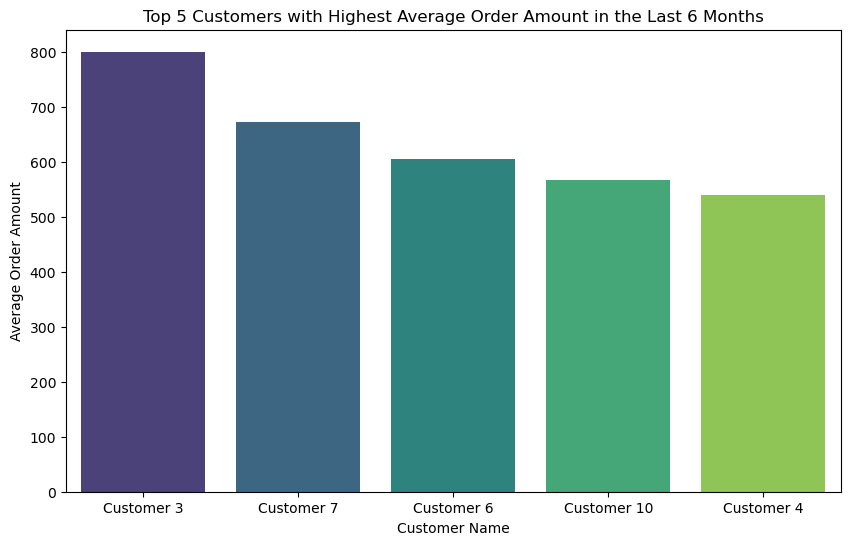

In [37]:
top_cust_df
plt.figure(figsize=(10,6))
sns.barplot(data= top_cust_df, x=top_cust_df['Name'], y=top_cust_df['AvgOrderAmount'], palette='viridis')
plt.title('Top 5 Customers with Highest Average Order Amount in the Last 6 Months')
plt.xlabel('Customer Name')
plt.ylabel('Average Order Amount')
plt.show()

# Customers with order value lower this year compared to previous year

In [38]:
lower_ord_cust_df

,CustomerID,Name


# Cumulative Purchase breakup by product category

In [39]:
cumulative_purchase_df

,CustomerID,CustomerName,Category,CumulativePurchase
0,1,Customer 1,Clothing,10734.817314
1,2,Customer 2,Clothing,15303.792559
2,3,Customer 3,Clothing,197.573677
3,4,Customer 4,Clothing,7853.206076
4,5,Customer 5,Clothing,8670.670913
...,...,...,...,...
95,96,Customer 96,Clothing,16107.422281
96,97,Customer 97,Clothing,25063.882858
97,98,Customer 98,Clothing,5045.803236
98,99,Customer 99,Clothing,169.642718


# Top 5 Selling products with sales bifurcated by product variants

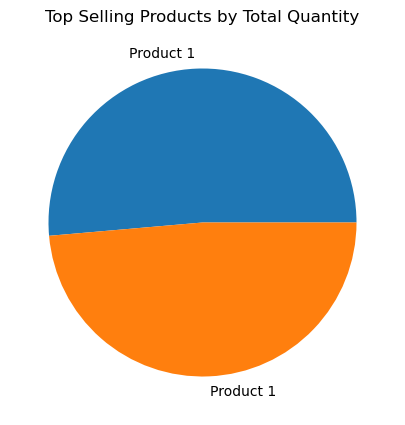

,ProductID,ProductName,VariantID,VariantName,TotalQuantity
0,1,Product 1,1,Variant 1 for Product 1,466
1,1,Product 1,2,Variant 2 for Product 1,441


In [40]:
plt.figure(figsize=(30,5))
plt.pie(x= top_selling_prod_df['TotalQuantity'], labels=top_selling_prod_df['ProductName'])
plt.title('Top Selling Products by Total Quantity')
plt.show()
top_selling_prod_df

In [41]:
conn = sqlite3.connect('E_commerce.db')

# Total orders per month in the current year
order_per_month_cy = pd.read_sql_query("""
                                       SELECT
                                       STRFTIME('%m',OrderDate) AS Month,
                                       COUNT(*) AS TotalOrders
                                       FROM
                                            'Order'
                                       WHERE
                                            STRFTIME('%Y',OrderDate) = STRFTIME('%Y',DATE('now'))
                                       GROUP BY
                                            Month
                                       ORDER BY
                                            Month;
                                       """,conn)
# Top 3 customers by total amount spent
top_cust_df = pd.read_sql_query("""
                                SELECT
                                    c.CustomerID,
                                    c.Name,
                                    SUM(TotalAmount) AS TotalSpent
                                FROM
                                    Customer c
                                JOIN
                                    'Order' o ON c.CustomerID = o.CustomerID
                                GROUP BY
                                    c.CustomerID,
                                    c.Name
                                ORDER BY
                                    TotalSpent DESC
                                LIMIT 3;
                                """,conn)
# Total Revenue from orders in the last 3 month
last_3_month_revenue = pd.read_sql_query("""
                                SELECT
                                    STRFTIME('%m', OrderDate) AS Month,
                                    SUM(TotalAmount) AS TotalRevenue
                                FROM
                                    'Order'
                                WHERE
                                    OrderDate >= DATE('now','-3 month');
                                """,conn)
conn.close()

# Total Order per Month in CY

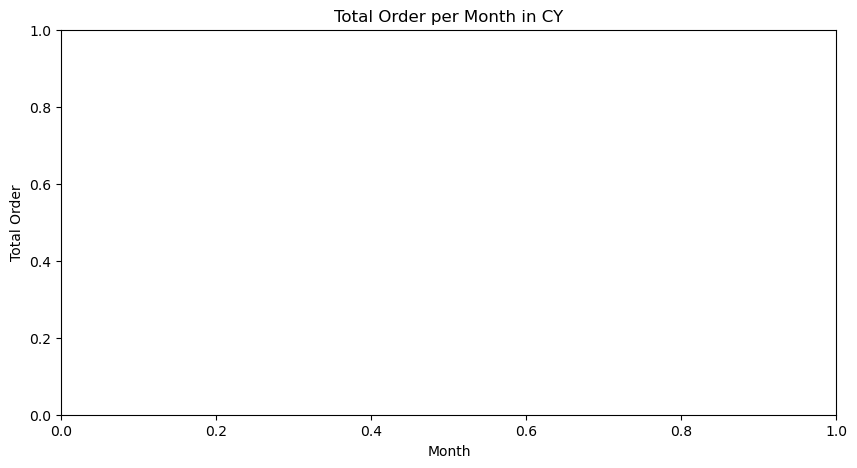

In [42]:
plt.figure(figsize=(10,5))
ax = sns.lineplot(data = order_per_month_cy, x='Month', y= 'TotalOrders')
for bars in ax.containers:
    ax.bar_label(bars)
plt.title('Total Order per Month in CY')
plt.xlabel("Month")
plt.ylabel("Total Order")
plt.show()

# Top 3 Customers by Total Amount Spent

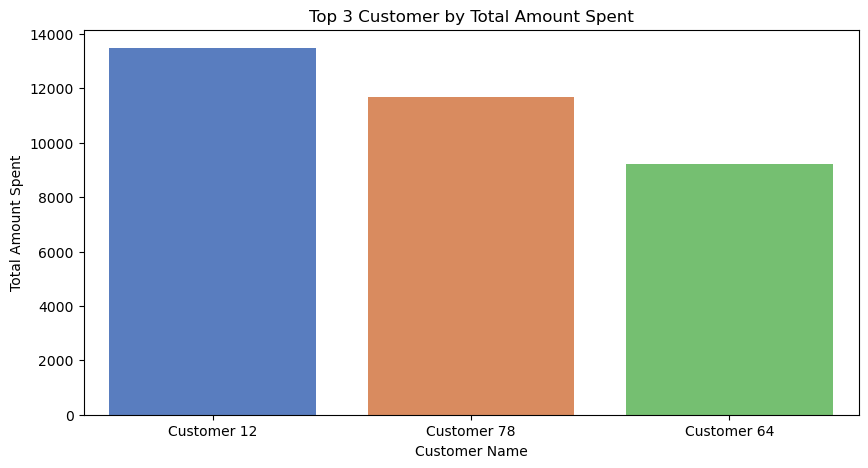

,CustomerID,Name,TotalSpent
0,12,Customer 12,13480.782229
1,78,Customer 78,11679.135899
2,64,Customer 64,9236.308824


In [43]:
plt.figure(figsize=(10,5))
sns.barplot(data=top_cust_df, x = 'Name', y = 'TotalSpent', palette = 'muted')
plt.title('Top 3 Customer by Total Amount Spent')
plt.xlabel('Customer Name')
plt.ylabel('Total Amount Spent')
plt.show()
top_cust_df

In [44]:
last_3_month_revenue

,Month,TotalRevenue
0,None,None


# Number of distinct product variants per category, order by the most variants

In [45]:
conn = sqlite3.connect('E_commerce.db')

distinct_variants = pd.read_sql_query("""
                                      SELECT
                                        p.Category,
                                        COUNT(DISTINCT pv.VariantID) AS DistinctVariants
                                      FROM
                                        Product p
                                      JOIN
                                        ProductVariant pv ON p.ProductID = pv.ProductID
                                      JOIN
                                        OrderItem oi ON pv.VariantID = oi.VariantID
                                      GROUP BY
                                        p.Category
                                      ORDER BY
                                        DistinctVariants DESC;
                                      """,conn)
conn.close()

In [46]:
distinct_variants

,Category,DistinctVariants
0,Clothing,2


# Customers who placed orders with Total Quantity > 15 across all orders

In [47]:
conn = sqlite3.connect('E_commerce.db')
cust_with_high_qty = pd.read_sql_query("""
                                       SELECT
                                        c.CustomerID,
                                        c.Name AS CustomerName,
                                        total_qty.TotalQuantity
                                       FROM
                                        Customer c
                                       JOIN
                                        'Order' o ON c.CustomerID = o.CustomerID
                                       JOIN
                                        (
                                            SELECT
                                                OrderID,
                                                SUM(Quantity) AS TotalQuantity
                                            FROM
                                                OrderItem
                                            GROUP BY
                                                OrderID
                                       ) AS total_qty ON o.OrderID = total_qty.OrderID
                                       WHERE
                                            total_qty.TotalQuantity > 15;
                                       """,conn)
conn.close()

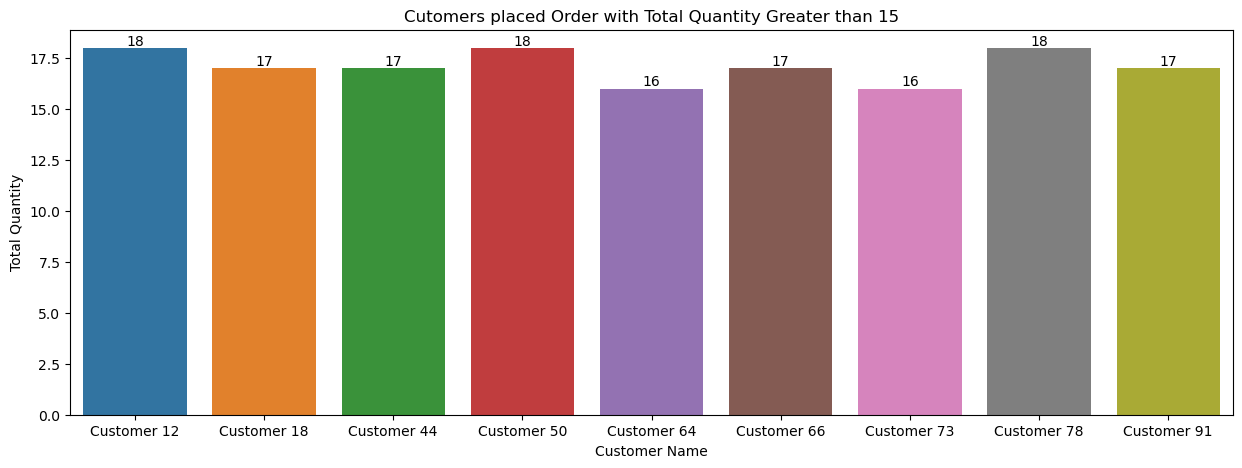

,CustomerID,CustomerName,TotalQuantity
0,12,Customer 12,18
1,18,Customer 18,17
2,44,Customer 44,17
3,50,Customer 50,18
4,64,Customer 64,16
5,66,Customer 66,17
6,73,Customer 73,16
7,78,Customer 78,18
8,91,Customer 91,17


In [69]:
plt.figure(figsize=(15,5))
ax = sns.barplot(data= cust_with_high_qty, x = 'CustomerName', y = 'TotalQuantity')
for bars in ax.containers:
    ax.bar_label(bars)
plt.title('Cutomers placed Order with Total Quantity Greater than 15')
plt.xlabel('Customer Name')
plt.ylabel('Total Quantity')
plt.show()
cust_with_high_qty

# Top 3 months by average order amount in the current year

In [49]:
conn = sqlite3.connect('E_commerce.db')
top_3_month_by_avg = pd.read_sql_query("""
                                       SELECT
                                       STRFTIME('%m', OrderDate) AS Month,
                                       AVG(TotalAmount) AS AvgOrderAmount
                                       FROM
                                            'Order'
                                       WHERE
                                            STRFTIME('%Y', OrderDate) = STRFTIME('%Y', DATE('now'))
                                       GROUP BY
                                            Month
                                       ORDER BY
                                            AvgOrderAmount DESC
                                       LIMIT 3;
                                       """,conn)
conn.close()

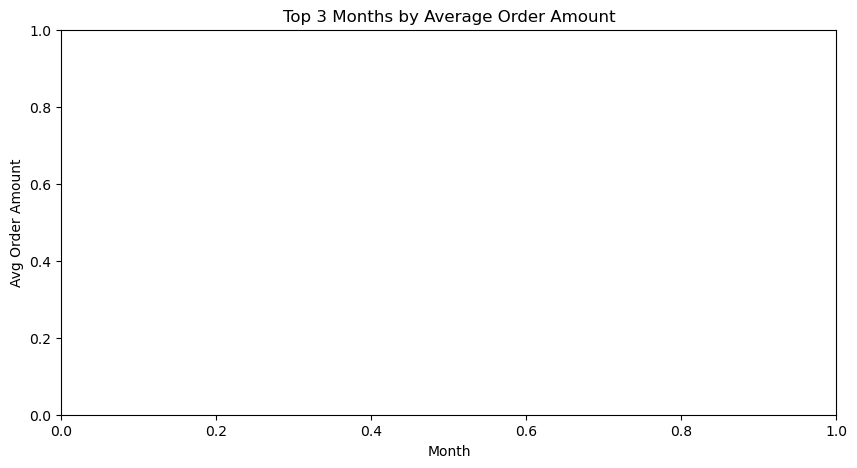

,Month,AvgOrderAmount


In [50]:
plt.figure(figsize = (10,5))
sns.lineplot(data = top_3_month_by_avg, x = 'Month', y = 'AvgOrderAmount')
plt.xlabel('Month')
plt.ylabel('Avg Order Amount')
plt.title("Top 3 Months by Average Order Amount")
plt.show()
top_3_month_by_avg

# Monthly Revenue and Growth Rate

In [51]:
conn = sqlite3.connect('E_commerce.db')
monthly_revenue = pd.read_sql_query("""
                                    WITH MonthlyRev AS (
                                    SELECT
                                        STRFTIME('%Y-%m', OrderDate) AS Month,
                                        SUM(TotalAmount) AS TotalRevenue
                                    FROM
                                        'Order'
                                    WHERE
                                        OrderDate >= DATE('now' - '-12 months')
                                    GROUP BY
                                        Month
                                    )
                                        SELECT
                                            m1.Month,
                                            m1.TotalRevenue AS CMRevenue,
                                            m2.TotalRevenue AS LMRevenue,
                                            ROUND(((m1.TotalRevenue - m2.TotalRevenue) * 100.0 / m2.TotalRevenue), 2) AS GrowthRate
                                            
                                        FROM
                                            MonthlyRev m1
                                        LEFT JOIN
                                            MonthlyRev m2 on STRFTIME('%Y - %m', DATE(m1.Month, '-1 month')) = m2.Month;
                                    """, conn)
conn.close()

C:\Users\asus\AppData\Local\Temp\ipykernel_5012\1860484539.py:2: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(data = monthly_revenue, x = 'Month', y = 'CMRevenue', palette= 'muted')


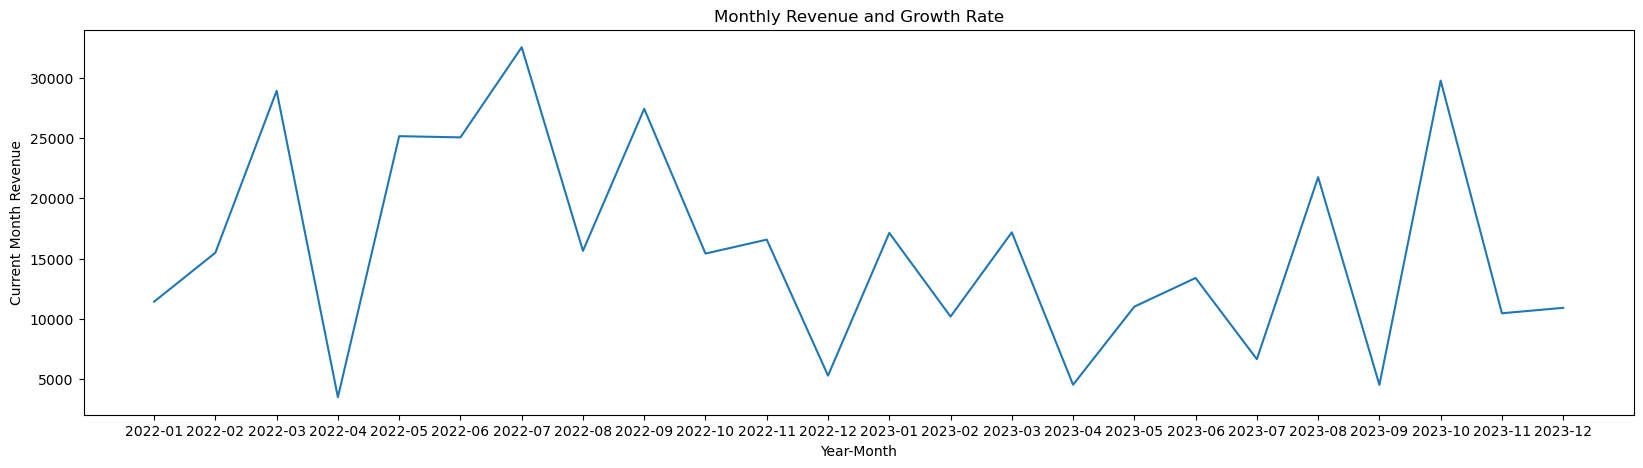

,Month,CMRevenue,LMRevenue,GrowthRate
0,None,26819.690000,None,None
1,2022-01,11429.326444,None,None
2,2022-02,15490.071405,None,None
3,2022-03,28912.426366,None,None
4,2022-04,3507.676202,None,None
5,2022-05,25154.559574,None,None
6,2022-06,25055.861484,None,None
7,2022-07,32531.481545,None,None
8,2022-08,15647.099758,None,None
9,2022-09,27426.599095,None,None


In [52]:
plt.figure(figsize=(20,5))
sns.lineplot(data = monthly_revenue, x = 'Month', y = 'CMRevenue', palette= 'muted')
plt.title('Monthly Revenue and Growth Rate')
plt.xlabel('Year-Month')
plt.ylabel('Current Month Revenue')
plt.show()
monthly_revenue

# Customer who have purchased from at least 3 different product categories

In [53]:
conn = sqlite3.connect('E_commerce.db')
cust_multi_category = pd.read_sql_query("""
                                        SELECT
                                            c.CustomerID,
                                            c.Name AS CustomerName
                                        FROM
                                            Customer c
                                        JOIN
                                            'Order' o ON c.CustomerID = o.CustomerID
                                        JOIN
                                            OrderItem oi ON o.OrderID = oi.OrderID
                                        JOIN
                                            ProductVariant pv ON oi.VariantID = pv.VariantID
                                        JOIN
                                            Product p ON pv.ProductID = p.ProductID
                                        GROUP BY
                                            c.CustomerID,
                                            c.Name
                                        HAVING
                                            COUNT(DISTINCT p.Category) >= 3;
                                        """, conn)
conn.close()

In [54]:
cust_multi_category

,CustomerID,CustomerName


# Top 5 Products by Average Selling Price

In [55]:
conn = sqlite3.connect('E_commerce.db')
top_product_by_asp = pd.read_sql_query("""
                                       SELECT
                                        p.ProductID,
                                        p.ProductName,
                                        AVG(oi.Price) AS ASP
                                       FROM
                                        Product p
                                       JOIN
                                        ProductVariant pv ON p.ProductID = pv.ProductID
                                       JOIN
                                        OrderItem oi ON pv.VariantID = oi.VariantID
                                       GROUP BY
                                        p.ProductID,
                                        p.ProductName
                                       ORDER BY
                                            ASP DESC
                                       LIMIT 5;
                                       """, conn)
conn.close()

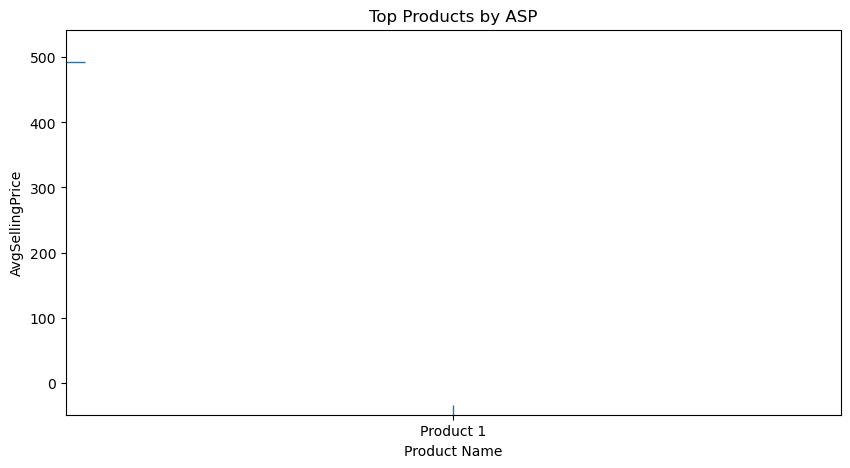

,ProductID,ProductName,ASP
0,1,Product 1,493.160566


In [56]:
plt.figure(figsize = (10,5))
sns.rugplot(data= top_product_by_asp, x ='ProductName', y ='ASP')
plt.title('Top Products by ASP')
plt.xlabel('Product Name')
plt.ylabel('AvgSellingPrice')
plt.show()
top_product_by_asp

# Products with no Orders Placed

In [57]:
conn = sqlite3.connect('E_commerce.db')
prod_zero_order = pd.read_sql_query("""
                                    SELECT
                                        p.ProductID,
                                        p.ProductName
                                    FROM
                                        Product p
                                    LEFT JOIN
                                        ProductVariant pv ON p.ProductID = pv.ProductID
                                    LEFT JOIN
                                        OrderItem oi ON pv.VariantID = oi.VariantID
                                    WHERE
                                        oi.OrderItemID IS NULL;
                                    """, conn)
conn.close()

<Figure size 1500x500 with 0 Axes>

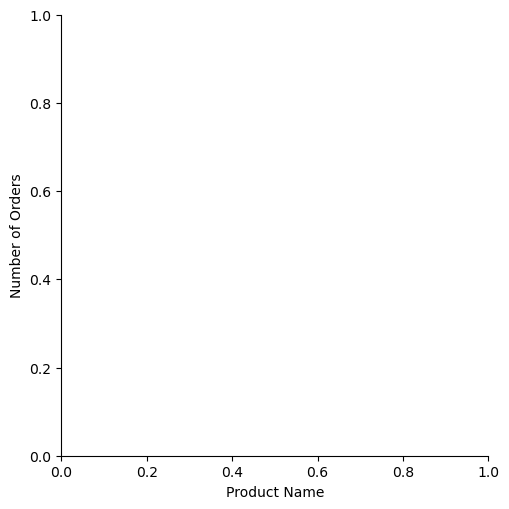

,ProductID,ProductName


In [58]:
plt.figure(figsize = (15,5))
no_prod  = prod_zero_order['ProductID'].value_counts()
sns.catplot(data = prod_zero_order, x = 'ProductName', y = no_prod, palette= 'muted' )
plt.xlabel('Product Name')
plt.ylabel('Number of Orders')
plt.show()
prod_zero_order

# Customer who have purchased only in the 'Electronics' Category

In [59]:
conn = sqlite3.connect('E_commerce.db')
cust_elc_cat = pd.read_sql_query("""
                                 SELECT
                                    c.CustomerID,
                                    c.Name AS CustoemrName
                                 FROM
                                    Customer c
                                 JOIN
                                    'Order' o ON c.CustomerID = o.CustomerID
                                 JOIN
                                    OrderItem oi ON oi.OrderID = o.OrderID
                                 JOIN
                                    ProductVariant pv ON pv.VariantID = oi.VariantID
                                 JOIN
                                    Product p ON p.ProductID = pv.ProductID
                                 WHERE
                                    p.Category = 'Electronics'
                                 GROUP BY
                                    c.CustomerID,
                                    c.Name
                                 HAVING
                                    COUNT(DISTINCT p.Category) = 1;
                                 """, conn)
conn.close()

In [60]:
cust_elc_cat

,CustomerID,CustoemrName


# Monthly Revenue Comparison and Growth Rate

In [61]:
conn = sqlite3.connect('E_commerce.db')
monthly_reve_gr = pd.read_sql_query("""
                                    WITH MonthlyRevenue AS (
                                    SELECT
                                        DATE(OrderDate, 'Start of month') AS Month,
                                        SUM(TotalAmount) AS TotalRevenue
                                    FROM
                                        'Order'
                                    WHERE
                                        OrderDate >= DATE('now' , '-12 months', 'start of month') ----- Start of current month 12 months ago
                                        AND OrderDate < DATE('now', 'start of month') ------ Start of current month
                                    GROUP BY
                                        Month
                                    )
                                    SELECT
                                        m1.Month,
                                        m1.TotalRevenue AS CM_Revenue,
                                        COALESCE(m2.TotalRevenue, 0) AS PM_Revenue,
                                        CASE WHEN m2.TotalRevenue > 0 THEN (m1.TotalRevenue - m2.TotalRevenue) / m2.TotalRevenue ELSE NULL END AS GrowthRate
                                    FROM
                                        MonthlyRevenue m1
                                    LEFT JOIN
                                        MonthlyRevenue m2 ON DATE(m1.Month, '-1 month') = m2.Month
                                    ORDER BY
                                        GrowthRate DESC;
                                    """, conn)
conn.close()

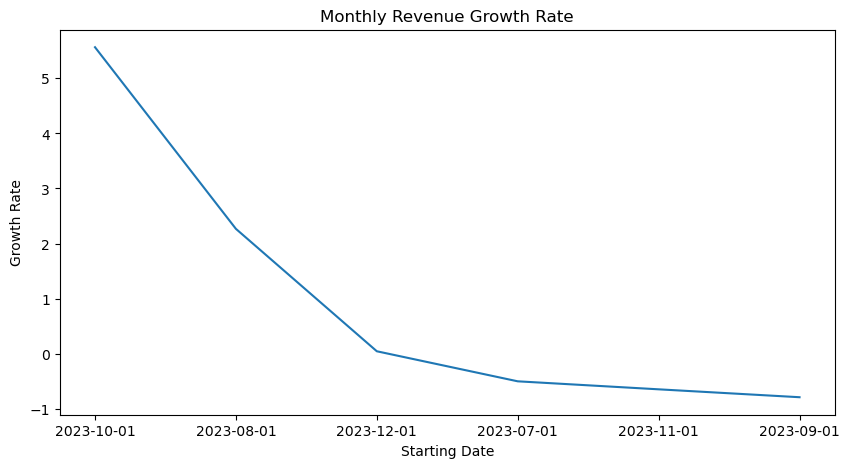

,Month,CM_Revenue,PM_Revenue,GrowthRate
0,2023-10-01,29761.705045,4532.909134,5.565696
1,2023-08-01,21759.266356,6661.312235,2.266514
2,2023-12-01,10920.821263,10470.404947,0.043018
3,2023-07-01,6661.312235,13396.569585,-0.502760
4,2023-11-01,10470.404947,29761.705045,-0.648192
5,2023-09-01,4532.909134,21759.266356,-0.791679
6,None,26819.690000,0.000000,NaN
7,2023-06-01,13396.569585,0.000000,NaN


In [62]:
plt.figure(figsize = (10,5))
sns.lineplot(data= monthly_reve_gr, x = 'Month', y = 'GrowthRate')
plt.title('Monthly Revenue Growth Rate')
plt.xlabel('Starting Date')
plt.ylabel('Growth Rate')
plt.show()
monthly_reve_gr

# Customers Who Purchased a specific product (ProductID = 1)

In [63]:
conn = sqlite3.connect('E_commerce.db')
cust_purch_prd = pd.read_sql_query("""
                                   SELECT
                                        c.CustomerID,
                                        c.Name AS CustomerName
                                   FROM
                                        Customer c
                                   JOIN
                                        'Order' o ON c.CustomerID = o.CustomerID
                                   JOIN
                                        OrderItem oi ON o.OrderID = oi.OrderID
                                   JOIN
                                        ProductVariant pv ON oi.VariantID = pv.VariantID
                                   WHERE
                                        pv.ProductID = 1 -- Replace with desired ProductID
                                   GROUP BY
                                        c.CustomerID,
                                        c.Name;
                                    """,conn)
conn.close()

In [64]:
cust_purch_prd

,CustomerID,CustomerName
0,1,Customer 1
1,2,Customer 2
2,3,Customer 3
3,4,Customer 4
4,5,Customer 5
...,...,...
95,96,Customer 96
96,97,Customer 97
97,98,Customer 98
98,99,Customer 99


# Products with on Orders in the Last 6 Month

In [65]:
conn = sqlite3.connect('E_commerce.db')
prd_no_order = pd.read_sql_query("""
                                 SELECT
                                    p.ProductID,
                                    p.ProductName
                                 FROM
                                    Product p
                                 LEFT JOIN
                                    ProductVariant pv ON p.ProductID = pv.ProductID
                                 LEFT JOIN
                                    OrderItem oi ON pv.VariantID = oi.VariantID
                                    AND oi.OrderID IN(
                                        SELECT OrderID FROM 'Order' WHERE OrderDate >= DATE('now', '-6 months')
                                 )
                                 WHERE
                                    oi.OrderItemID IS NULL
                                 GROUP BY
                                    p.ProductID,
                                    p.ProductName;
                                 """,conn)
conn.close()

In [66]:
prd_no_order

,ProductID,ProductName
0,1,Product 1


# Customers who purchased products from all categories

In [67]:
conn = sqlite3.connect('E_commerce.db')
customers_all_categories_df = pd.read_sql_query("""
        SELECT
            c.CustomerID,
            c.Name AS CustomerName
        FROM
            Customer c
        JOIN
            `Order` o ON c.CustomerID = o.CustomerID
        JOIN
            OrderItem oi ON o.OrderID = oi.OrderID
        JOIN
            ProductVariant pv ON oi.VariantID = pv.VariantID
        JOIN
            Product p ON pv.ProductID = p.ProductID
        GROUP BY
            c.CustomerID,
            c.Name
        HAVING
            COUNT(DISTINCT p.Category) = (SELECT COUNT(DISTINCT Category) FROM Product);
    """, conn)
conn.close()

In [68]:
customers_all_categories_df

,CustomerID,CustomerName
0,1,Customer 1
1,2,Customer 2
2,3,Customer 3
3,4,Customer 4
4,5,Customer 5
...,...,...
95,96,Customer 96
96,97,Customer 97
97,98,Customer 98
98,99,Customer 99
